## Imports

In [661]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from keras.optimizers import Adam
from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
import word2vecReader as godin_embedding
import pickle
from gensim.models import KeyedVectors
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

## Loading Data

In [603]:
def load_data_from_json(filename):
    with open(filename,'r') as f:
        return json.load(f)

In [604]:
master_dict = load_data_from_json('dataset/master_train.json')

In [605]:
master_dict

{'1': {'info': [{'aspects': "['Corporate/Appointment']",
    'sentiment_score': '-0.374',
    'snippets': "['set to step down']",
    'target': 'Royal Mail'}],
  'sentence': 'Royal Mail chairman Donald Brydon set to step down'},
 '7': {'info': [{'aspects': "['Corporate/Risks', 'Correct Aspect 3']",
    'sentiment_score': '-0.24',
    'snippets': "['Facing Tough Competition', 'Aspects 3 Snippet']",
    'target': 'AstraZeneca'}],
  'sentence': 'Stakes High for AstraZeneca Heart Drug Facing Tough Competition'},
 '8': {'info': [{'aspects': "['Corporate/Sales/Failed Contract Discussion']",
    'sentiment_score': '-0.161',
    'snippets': "['Crest loses a third of Morrisons milk contract']",
    'target': 'Morrisons'}],
  'sentence': 'UPDATE 1-Dairy Crest loses a third of Morrisons milk contract'},
 '22': {'info': [{'aspects': "['Corporate/Appointment/Executive Appointment']",
    'sentiment_score': '0.137',
    'snippets': '["hires Aviva\'s David Hillier for multi-asset team"]',
    'target

## Into Data

In [606]:
def extract_data_from_dict(master_dict):
    id_sentence = []
    sentence = []
    aspect = []
    target = []
    for key in master_dict.keys():
        id_sentence.append(int(key))
        sentence.append(master_dict[key]['sentence'])
        temp_target=[]
        temp_aspect = []
        for element in master_dict[key]['info']:
            temp_target.append(element['target'])
            temp_aspect.append(eval(element['aspects']))
        target.append(temp_target)
        aspect.append(temp_aspect)
    return id_sentence,sentence,aspect,target

In [607]:
id_sentence,sentence,aspect,target = extract_data_from_dict(master_dict)

In [608]:
len(id_sentence),len(sentence),len(aspect),len(target)

(1002, 1002, 1002, 1002)

In [609]:
#converting data into flat str
sentence_f = []
id_sentence_f = []
target_f = []
aspect_f = []
for a0 in zip(aspect,target,sentence,id_sentence):
    for a1 in zip(a0[0],a0[1]):
        for a2 in a1[0]:
            aspect_f.append(a2)
            target_f.append(a1[1])
            sentence_f.append(a0[2])
            id_sentence_f.append(a0[3])

In [610]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(1101, 1101, 1101, 1101)

In [611]:
for i,v in enumerate(aspect_f):
    if v == 'Correct Aspect 3' or v == 'under threat':
        aspect_f.pop(i)
        sentence_f.pop(i)
        id_sentence_f.pop(i)
        target_f.pop(i)

In [612]:
aspect_f_level1= []
aspect_f_level2=[]
for asp in aspect_f:
    try:
        aspect_f_level1.append(asp.split('/')[0])
        aspect_f_level2.append(asp.split('/')[1])
    except:
        print(asp)
# aspect_f

In [613]:
#Correcting inconsistent labels:
#changing
# 'Central Banks'<-->'Central_Banks'
# 'Company Communication'<-->'Company_Communication'
# 'Dividend Policy'<-->'Dividend_Policy'
# 'Insider Activity'<-->'Insider_Activity'
# 'Opitions'<-->'Options'
# 'Price Action'<-->'Price_Action'
# 'Stategy'<-->'Strategy'
# 'Volatility'<-->"Volatility'"
for i,a in enumerate(aspect_f_level2):
    if a == 'Central_Banks':
        aspect_f_level2[i]='Central Banks'
    elif a=='Company_Communication':
        aspect_f_level2[i]='Company Communication'
    elif a=='Dividend_Policy':
        aspect_f_level2[i]='Dividend Policy'
    elif a=='Insider_Activity':
        aspect_f_level2[i]='Insider Activity'
    elif a=='Options':
        aspect_f_level2[i]='Opitions'
    elif a=='Price_Action':
        aspect_f_level2[i]='Price Action'
    elif a=='Stategy':
        aspect_f_level2[i]='Strategy'
    elif a=="Volatility'":
        aspect_f_level2[i]='Volatility'

In [614]:
len(aspect_f_level2),len(aspect_f_level1)

(1099, 1099)

In [615]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(1099, 1099, 1099, 1099)

In [616]:
n_label_level_1 = len(set(aspect_f_level1))
n_label_level_2 = len(set(aspect_f_level2))
n_label_level_1,n_label_level_2

(4, 27)

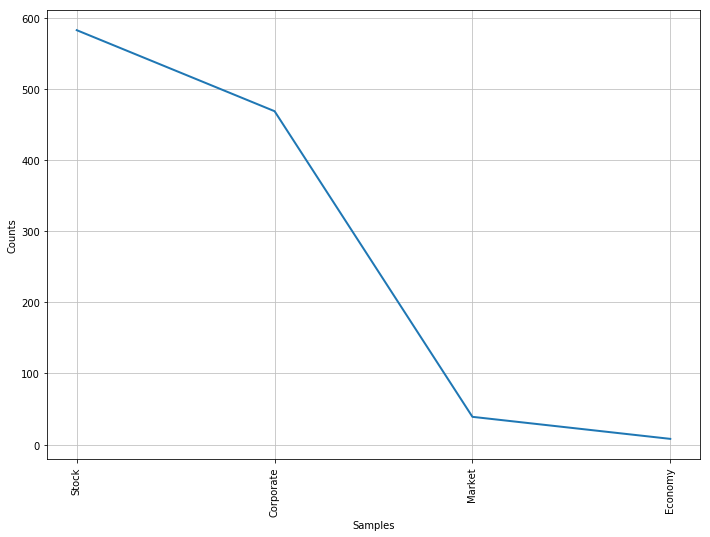

FreqDist({'Stock': 583, 'Corporate': 469, 'Market': 39, 'Economy': 8})


In [617]:
level1_freq = FreqDist(aspect_f_level1)
level1_freq.plot()
level1_freq.pprint()

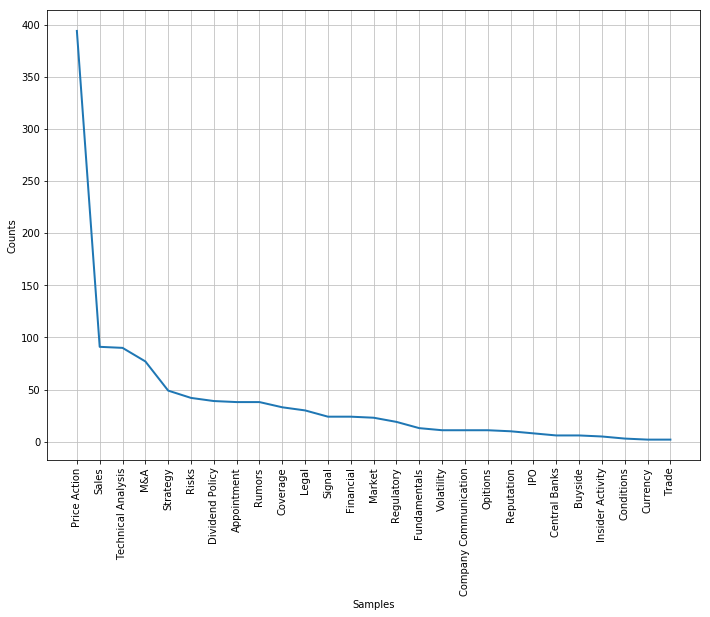

FreqDist({'Price Action': 394, 'Sales': 91, 'Technical Analysis': 90, 'M&A': 77, 'Strategy': 49, 'Risks': 42, 'Dividend Policy': 39, 'Appointment': 38, 'Rumors': 38, 'Coverage': 33, 'Legal': 30, 'Signal': 24, 'Financial': 24, 'Market': 23, 'Regulatory': 19, 'Fundamentals': 13, 'Volatility': 11, 'Company Communication': 11, 'Opitions': 11, 'Reputation': 10, 'IPO': 8, 'Central Banks': 6, 'Buyside': 6, 'Insider Activity': 5, 'Conditions': 3, 'Currency': 2, 'Trade': 2})


In [618]:
level2_freq = FreqDist(aspect_f_level2)
level2_freq.plot()
level2_freq.pprint(n_label_level_2)

In [619]:
#extracting least frequent level 2
# n_least_class_to_extract = 25
# least_freq_level2 = list()
# for x in level2_freq.most_common()[-n_least_class_to_extract:]:
#     least_freq_level2.append(x[0])
# least_freq_level2

In [620]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [621]:
L2_L1_pair = get_level_pairs(aspect_f_level1,aspect_f_level2)
L1_L2_pair = get_level_pairs(aspect_f_level2,aspect_f_level1)

In [622]:
L1_L2_pair

{'Corporate': ['Company Communication',
  'Risks',
  'Legal',
  'Technical Analysis',
  'Regulatory',
  'Rumors',
  'Sales',
  'Strategy',
  'Financial',
  'M&A',
  'Dividend Policy',
  'Appointment',
  'Reputation'],
 'Economy': ['Central Banks', 'Trade'],
 'Market': ['Market', 'Volatility', 'Conditions', 'Currency'],
 'Stock': ['Insider Activity',
  'Opitions',
  'Signal',
  'IPO',
  'Fundamentals',
  'Buyside',
  'Coverage',
  'Price Action',
  'Technical Analysis']}

In [624]:
L2_L1_pair

{'Appointment': ['Corporate'],
 'Buyside': ['Stock'],
 'Central Banks': ['Economy'],
 'Company Communication': ['Corporate'],
 'Conditions': ['Market'],
 'Coverage': ['Stock'],
 'Currency': ['Market'],
 'Dividend Policy': ['Corporate'],
 'Financial': ['Corporate'],
 'Fundamentals': ['Stock'],
 'IPO': ['Stock'],
 'Insider Activity': ['Stock'],
 'Legal': ['Corporate'],
 'M&A': ['Corporate'],
 'Market': ['Market'],
 'Opitions': ['Stock'],
 'Price Action': ['Stock'],
 'Regulatory': ['Corporate'],
 'Reputation': ['Corporate'],
 'Risks': ['Corporate'],
 'Rumors': ['Corporate'],
 'Sales': ['Corporate'],
 'Signal': ['Stock'],
 'Strategy': ['Corporate'],
 'Technical Analysis': ['Corporate', 'Stock'],
 'Trade': ['Economy'],
 'Volatility': ['Market']}

In [626]:
with open('models/l2_l1_map.json','w') as f:
    json.dump(L2_L1_pair,f,indent=4)

In [627]:
C_Stock = 0
C_Corporate = 0
for pair in zip(aspect_f_level1,aspect_f_level2):
    if pair[1] == 'Technical Analysis':
        if pair[0] == 'Stock':
            C_Stock+=1
        else:
            C_Corporate+=1
print('C_Stock == ',C_Stock)
print('C_Corporate ==',C_Corporate)

C_Stock ==  89
C_Corporate == 1


In [629]:
#checking pos tags of target and there freq
# target_tags_freq = dict()
# for s in sentence_f:
#     text = word_tokenize(s)
#     for pair in pos_tag(text):
#         if pair[0] in target_f:
#             if pair[1] in target_tags_freq.keys():
#                 target_tags_freq[pair[1]]+=1
#             else:
#                 target_tags_freq[pair[1]] =1
# target_tags_freq

In [630]:
#number of words having same pos tags but not target
# count = 0
# for s in sentence_f:
#     text = word_tokenize(s)
#     for pair in pos_tag(text):
#         if pair[1] in target_tags_freq.keys() and pair[0] not in target_f:
#             count+=1
# count

## pre-processing data

In [631]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [632]:
sentenceX = [clean_sentence(x) for x in sentence_f]

In [633]:
# sentenceX

In [634]:
Level_1Y = aspect_f_level1
Level_2Y = aspect_f_level2

In [635]:
#clubing least n freq Level 1class together into Other
# Level_2_lables_clubed = list()
# for aspect in Level_2Y:
#     if aspect in least_freq_level2:
#         Level_2_lables_clubed.append('Other')
#     else:
#         Level_2_lables_clubed.append(aspect)
# len(Level_2_lables_clubed),len(Level_2Y)

In [636]:
# level2_clubed_freq = FreqDist(Level_2_lables_clubed)
# level2_clubed_freq.plot()
# level2_clubed_freq.pprint()

In [637]:
lengths = [len(s.split()) for s in sentenceX]

In [716]:
# print('max len = ',max(lengths))
# sns.distplot(lengths)

In [639]:
max_length  = 12

## ----

In [640]:
tranLines = sentenceX
trainLabels = aspect_f_level2
# trainLabels = Level_2_lables_clubed

In [641]:
no_of_classes = len(set(trainLabels))
no_of_classes

27

In [642]:
# trainX,testX = tranLines[:int(len(tranLines)*0.9)],tranLines[int(len(tranLines)*0.9):]
# trainY,testY = trainLabels[:int(len(trainLabels)*0.9)],trainLabels[int(len(trainLabels)*0.9):]
trainX, testX, trainY, testY = train_test_split(tranLines, trainLabels, test_size=0.1)

In [643]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))

989 989
110 110


In [644]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [645]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [646]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 12
Vocabulary size: 2987
(989, 12) (110, 12)


In [647]:
def convert_lables(trainY,testY):
    le = preprocessing.LabelEncoder()
    le.fit(trainY+testY)
    temp1 = le.transform(trainY)
    temp2 = le.transform(testY)
    return to_categorical(temp1,no_of_classes),to_categorical(temp2,no_of_classes),le.classes_

In [648]:
trainY,testY,lable_encoding = convert_lables(trainY,testY)

In [653]:
with open('models/label_encoding.json','w') as f:
    json.dump({'lables_index':list(lable_encoding)},f)

## word embeddings

In [654]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [656]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
embeddings_index_glove = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
embedding_matrix_glove = get_GloVe_embedding_matrix(embeddings_index_glove)

In [657]:
#fast text word embedding
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
#                 sentence = sentence.encode('UTF-8')
#                 print(sentence)
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [658]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [ ]:
#need to fix this
fast_text_model = load_fast_text_model(sentence)
embedding_matrix_fast_text = get_fast_text_matrix(fast_text_model)

In [659]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading the model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [660]:
def get_godin_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,400))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix


In [ ]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")
embedding_matrix_godin = get_godin_embedding_matrix(godin_model)

In [513]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [514]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [664]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

## Hyper parameters

In [675]:
para_learning_rate = Real(low=1e-4, high=1e-1, prior='log-uniform',name='learning_rate')

In [676]:
para_dropout = Real(low=0.1, high=0.5,name = 'dropout')

In [677]:
para_lstm_out = Categorical(categories=[300,400,500,600,700], name='lstm_out')

In [678]:
para_n_hidden_layer = Integer(low=1,high=2,name = 'n_hidden_layer')

In [679]:
# 'embedding_matrix_fast_text',
para_em = Categorical(categories=['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free'],name='em')

In [680]:
para_em_trainable_flag = Categorical(categories=[True,False],name='em_trainable_flag')

In [681]:
para_free_em_dim = Categorical(categories=[100,300,400],name='free_em_dim')

In [682]:
para_batch_size = Categorical(categories=[16,32,50,100,150],name='batch_size')

In [683]:
para_epoch = Categorical(categories=[10,20,30,50,70,100,150],name='epoch')

In [689]:
parameters = [para_learning_rate,para_dropout,para_lstm_out,para_n_hidden_layer,para_em,para_em_trainable_flag,para_free_em_dim,para_batch_size,para_epoch]

In [684]:
default_parameters = [1e-1,0.2,400,2,'embedding_matrix_godin',False,300,32,20]

## Model

In [686]:
def defina_model(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,free_em_dim):
    model = Sequential()
    
    if em == 'free':
        model.add(Embedding(vocab_size, free_em_dim))
    else:
        model.add(Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=max_length,trainable = trainable_flag))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=dropout)))
    for i in range(n_hidden_layer):
        model.add(Dense(int((2*lstm_out+no_of_classes)/2)),activation='relu')
    model.add(Dense(no_of_classes,activation='softmax'))
    optimizer = Adam(lr=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer=optimizer,metrics = ['accuracy'])
    print(model.summary())
    return model

In [687]:
#dict to store performance of all models
record = dict()
key=0

In [691]:
@use_named_args(dimensions=parameters)
def fitness(learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,free_em_dim,batch_size,epoch):
# n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,free_em_dim,em_trainable_flag
    # Print the hyper-parameters.
    global key
    global record
    print('-----------------------------combination no={0}------------------'.format(key))
    print('learning rate ==>',learning_rate)
    print('dropout==>',dropout)
    print('lstm_out==>',lstm_out)
    print('n_hidden_layer==>',n_hidden_layer)
    print('em==>',em)
    print('em_trainable_flag ==>',em_trainable_flag)
    print('free_em_dim==>',free_em_dim)
    print('batch_size==>',batch_size)
    print('epocs==>',epoch)

    # Create the neural network with these hyper-parameters.
    model = define_model(learning_rate=learning_rate,
                         dropout=dropout,
                         lstm_out=lstm_out,
                         n_hidden_layer=n_hidden_layer,
                         em=em,
                         em_trainable_flag=em_trainable_flag,
                         free_em_dim=free_em_dim)
    
    # Use Keras to train the model.
    history_object = model.fit(trainX, trainY, epochs=epoch,batch_size=batch_size)


    pred = model.predict(testX)
    test_label_act = [lable_encoding[x.argmax()] for x in testY]
    test_label_pred = [lable_encoding[x.argmax()] for x in pred]
    f1_s = f1_score(test_label_act,test_label_pred,'macro')
    
    
    

    # Print the classification accuracy.
    print("F1_macro: {0:.2%}".format(f1_s))
    
    
    record[key] = {'parameters':[learning_rate,dropout,lstm_out,n_hidden_layer,em,em_trainable_flag,free_em_dim,batch_size,epoch],'F1_macro':f1_s}
    with open('models/record.pickle', 'wb') as handle:
        pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    model.save('models/'+str(key)+'.h5')
    
    key+=1
    
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -f1_s

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=parameters,
                            acq_func='EI',
                            n_calls=11,
                            x0=default_parameters)

In [ ]:
with open('models/record.pickle', 'wb') as handle:
    pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [692]:
# model = defina_model()

In [693]:
# history_object = model.fit(trainX, trainY, epochs=20,batch_size=32)

In [694]:
# model.evaluate(testX,testY)

In [695]:
# pred = model.predict(testX)

In [696]:
# test_label_act = [lable_encoding[x.argmax()] for x in testY]
# test_label_pred = [lable_encoding[x.argmax()] for x in pred]

In [697]:
# cnf_matrix = confusion_matrix(test_label_act, test_label_pred)
# cnf_matrix

In [698]:
# ConfusionMatrix(test_label_act, test_label_pred).plot(backend='seaborn')

In [699]:
# #get metric scores
# def print_metric(yacc,ypred,avg_type=None):
#     print('---------------------avg type = {0}---------------------------------------------'.format(avg_type))
#     print('F1 score == ', f1_score(yacc,ypred,average=avg_type))
#     print('precision score == ', precision_score(yacc,ypred,average=avg_type))
#     print('recall score == ', recall_score(yacc,ypred,average=avg_type))
#     print('accuracy score == ', accuracy_score(yacc,ypred))

In [700]:
# print_metric(test_label_act,test_label_pred)
# print_metric(test_label_act,test_label_pred,'micro')
# print_metric(test_label_act,test_label_pred,'macro')
# print_metric(test_label_act,test_label_pred,'weighted')

## looking into data to find a approx threshold

In [701]:
# Sentence_multiple_aspect = dict()
# Sentence_single_aspect = list()
# for s1 in sentence_f:
#     temp = set()
#     for s2,a2 in zip(sentence_f,aspect_f_level2):  
#         if s1 == s2:
#             temp.add(a2)
#     if len(temp)>1:
#         Sentence_multiple_aspect[s1] = list(temp)
#     else:
#         Sentence_single_aspect.append(s1)
        

In [702]:
# Sentence_multiple_aspect

In [703]:
# test_multiple = Sentence_multiple_aspect.keys()
# test_multiple = encode_text(tokenizer, test_multiple, max_length)
# test_multiple_labels = [Sentence_multiple_aspect[x] for x in Sentence_multiple_aspect.keys()]

In [704]:
# test_multiple_pred = model.predict(test_multiple)

In [705]:
# test_multiple_label_pred = [lable_encoding[x.argmax()] for x in test_multiple_pred]

In [534]:
#finding out threshold

In [706]:
# i = np.where( lable_encoding =='Legal' )
# int(i[0])

# for x in enumerate(lable_encoding):
#     print(x)

In [707]:
# prob_values_of_multiclass_labels = dict()
# # 'act_label_prob':[],'predicted_lable_prob':[],'max_other':[]
# for i,t in enumerate(zip(test_multiple_label_pred,test_multiple_labels)):
#     act_label_prob = []
#     flag_correct = False
#     for x in t[1]:
#         act_label_prob.append(test_multiple_pred[i][int(np.where(lable_encoding ==x)[0])])
#     predicted_lable_prob = test_multiple_pred[i][int(np.where(lable_encoding ==t[0])[0])]
#     big = 0
#     if predicted_lable_prob in act_label_prob:
#         flag_correct=True
#     for x in test_multiple_pred[i]:
#         if x>big and x not in act_label_prob and x!=predicted_lable_prob:
#             big = x
#     prob_values_of_multiclass_labels[i] = {'act_label_prob':act_label_prob,'predicted_lable_prob':predicted_lable_prob,'max_other':big,'flag_correct':flag_correct}
    

In [708]:
# prob_values_of_multiclass_labels

In [709]:
# #calculating diff between min(act_label_prob) and max_other
# diff_values = []
# min_act_pred_values =[]
# max_other = []
# for key in prob_values_of_multiclass_labels.keys():
#     if prob_values_of_multiclass_labels[key]['flag_correct'] == True:
#         diff_values.append(min(prob_values_of_multiclass_labels[key]['act_label_prob'])-prob_values_of_multiclass_labels[key]['max_other'])
#         min_act_pred_values.append(min(prob_values_of_multiclass_labels[key]['act_label_prob']))
#         max_other.append(prob_values_of_multiclass_labels[key]['max_other'])

In [710]:
# count = 0
# for x in zip(max_other,min_act_pred_values):
#     print(x)
#     if x[0]>x[1]:
#         count+=1
# print('number of max_other > min_act_pred_values == ',count)


# # print('Diffrence between min(act_label_prob) and max_other')
# # print('max == ',max(diff_values))
# # print('min == ',min(diff_values))
# # print('min predicted value ==',min(min_act_pred_values))

# # for x in max_other:
# #     if x>min(min_act_pred_values):
# #         count+=1
# print("----------diff values---------------")
# print(sorted(diff_values))

In [711]:
# threshold = 0.2

In [712]:
#seing how many single aspect sentences have pred prob > threshold for incorrect aspect
# Sentence_single_X = encode_text(tokenizer, Sentence_single_aspect, max_length)

In [713]:
# single_aspect_pred = model.predict(Sentence_single_X)

In [714]:
# C_single = list()
# for v in single_aspect_pred:
#     count = 0
#     for i in v:
#         if i>threshold:
#             count+=1
#     C_single.append(count)

In [715]:
# C_single.count(1),C_single.count(2),C_single.count(3),C_single.count(4),C_single.count(5)